Visualizing Jigsaw Puzzle Results

In [1]:
# First cell - imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import glob
from PIL import Image

In [2]:
# Second cell - configuration
# Paths
base_log_dir = "/cluster/home/muhamhz/JPDVT/image_model/logs/DataTexRecSSH"
base_results_dir = "/cluster/home/muhamhz/JPDVT/image_model/inference/DataTexRecSSH"

# Read the CSV files
datasets = ['Downsampled1', 'Downsampled2']
results_data = {}

for dataset in datasets:
    csv_path = os.path.join(base_log_dir, f"{dataset}_inference_progress.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # Calculate patch accuracy as percentage
        df['patch_accuracy'] = df['patch_matches'] / 9.0  # Assuming 3x3 grid
        results_data[dataset] = df
        print(f"{dataset}: Found {len(df)} processed images")
    else:
        print(f"Warning: No CSV file found for {dataset}")

Downsampled1: Found 27 processed images
Downsampled2: Found 18 processed images


In [3]:
# Third cell - statistics
for dataset, df in results_data.items():
    print(f"\n=== {dataset} Statistics ===")
    print(f"Total images: {len(df)}")
    
    # Perfect puzzles
    perfect = df[df['puzzle_correct'] == 1]
    print(f"Perfect puzzles: {len(perfect)} ({len(perfect)/len(df)*100:.1f}%)")
    
    # High accuracy results
    thresholds = [0.7, 0.8, 0.9]
    for t in thresholds:
        high_acc = df[df['patch_accuracy'] >= t]
        print(f"Patch accuracy ≥ {t*100:.0f}%: {len(high_acc)} ({len(high_acc)/len(df)*100:.1f}%)")
    
    # Show the highest accuracy results
    if not df.empty:
        print("\nTop 5 highest patch accuracies:")
        print(df.sort_values('patch_accuracy', ascending=False)[['filename', 'puzzle_correct', 'patch_accuracy']].head(5))


=== Downsampled1 Statistics ===
Total images: 27
Perfect puzzles: 8 (29.6%)
Patch accuracy ≥ 70%: 10 (37.0%)
Patch accuracy ≥ 80%: 8 (29.6%)
Patch accuracy ≥ 90%: 8 (29.6%)

Top 5 highest patch accuracies:
           filename  puzzle_correct  patch_accuracy
7   resized_053.png               1             1.0
4   resized_012.png               1             1.0
3   resized_010.png               1             1.0
22  resized_090.png               1             1.0
23  resized_102.png               1             1.0

=== Downsampled2 Statistics ===
Total images: 18
Perfect puzzles: 3 (16.7%)
Patch accuracy ≥ 70%: 3 (16.7%)
Patch accuracy ≥ 80%: 3 (16.7%)
Patch accuracy ≥ 90%: 3 (16.7%)

Top 5 highest patch accuracies:
             filename  puzzle_correct  patch_accuracy
7     resized_007.png               1        1.000000
8     resized_013.png               1        1.000000
16  resized_124-2.png               1        1.000000
2   resized_004-1.png               0        0.666667
6    

In [4]:
# Fourth cell - helper functions for visualization
def find_image_path(dataset, filename, puzzle_correct, patch_acc):
    """Find the image path based on filename and metrics"""
    results_dir = os.path.join(base_results_dir, dataset, "Grid3")
    
    # For reconstructed image
    pattern = f"{os.path.splitext(filename)[0]}_reconstructed_pAcc={puzzle_correct}_patchAcc={patch_acc:.2f}.png"
    recon_path = os.path.join(results_dir, pattern)
    
    # For original and scrambled
    orig_path = os.path.join(results_dir, f"{os.path.splitext(filename)[0]}_original.png")
    scrambled_path = os.path.join(results_dir, f"{os.path.splitext(filename)[0]}_random.png")
    
    # Check if files exist
    if not os.path.exists(recon_path):
        # Try alternative pattern (some flexibility in case filenames differ slightly)
        recon_files = glob.glob(os.path.join(results_dir, f"{os.path.splitext(filename)[0]}_reconstructed_*.png"))
        if recon_files:
            recon_path = recon_files[0]
    
    return orig_path, scrambled_path, recon_path

In [5]:
# Fifth cell - Display top N results for both datasets
def display_top_results(dataset_name, n=5, sort_by='patch_accuracy', ascending=False):
    """Display top N results from the specified dataset"""
    if dataset_name not in results_data:
        print(f"Dataset {dataset_name} not found in results data")
        return
        
    df = results_data[dataset_name]
    top_results = df.sort_values(sort_by, ascending=ascending).head(n)
    
    # Create a large figure to fit all images
    fig = plt.figure(figsize=(18, n*3))
    plt.suptitle(f"Top {n} results from {dataset_name} (sorted by {sort_by})", fontsize=16)
    
    # For each top result
    for i, (idx, row) in enumerate(top_results.iterrows()):
        filename = row['filename']
        puzzle_correct = row['puzzle_correct']
        patch_acc = row['patch_accuracy']
        
        # Get image paths
        orig_path, scrambled_path, recon_path = find_image_path(dataset_name, filename, puzzle_correct, patch_acc)
        
        # Check if images exist
        if not all(os.path.exists(p) for p in [orig_path, scrambled_path, recon_path]):
            print(f"Warning: Could not find all image files for {filename}")
            missing = []
            if not os.path.exists(orig_path): missing.append("original")
            if not os.path.exists(scrambled_path): missing.append("scrambled")
            if not os.path.exists(recon_path): missing.append("reconstructed")
            print(f"Missing: {', '.join(missing)}")
            continue
        
        # Create a row for this result (3 images side by side)
        ax1 = fig.add_subplot(n, 3, i*3+1)
        ax1.imshow(Image.open(orig_path))
        ax1.set_title(f"Original\n{os.path.basename(filename)}")
        ax1.axis('off')
        
        ax2 = fig.add_subplot(n, 3, i*3+2)
        ax2.imshow(Image.open(scrambled_path))
        ax2.set_title("Scrambled")
        ax2.axis('off')
        
        ax3 = fig.add_subplot(n, 3, i*3+3)
        ax3.imshow(Image.open(recon_path))
        ax3.set_title(f"Reconstructed\nPuzzle: {int(puzzle_correct)}, Patch Acc: {patch_acc:.2f}")
        ax3.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, top=0.95)
    plt.show()
    
    # Print summary of displayed images
    print(f"\nDisplayed top {n} images from {dataset_name}:")
    for i, (idx, row) in enumerate(top_results.iterrows()):
        print(f"{i+1}. {row['filename']} - Puzzle: {int(row['puzzle_correct'])}, Patch Acc: {row['patch_accuracy']:.2f}")

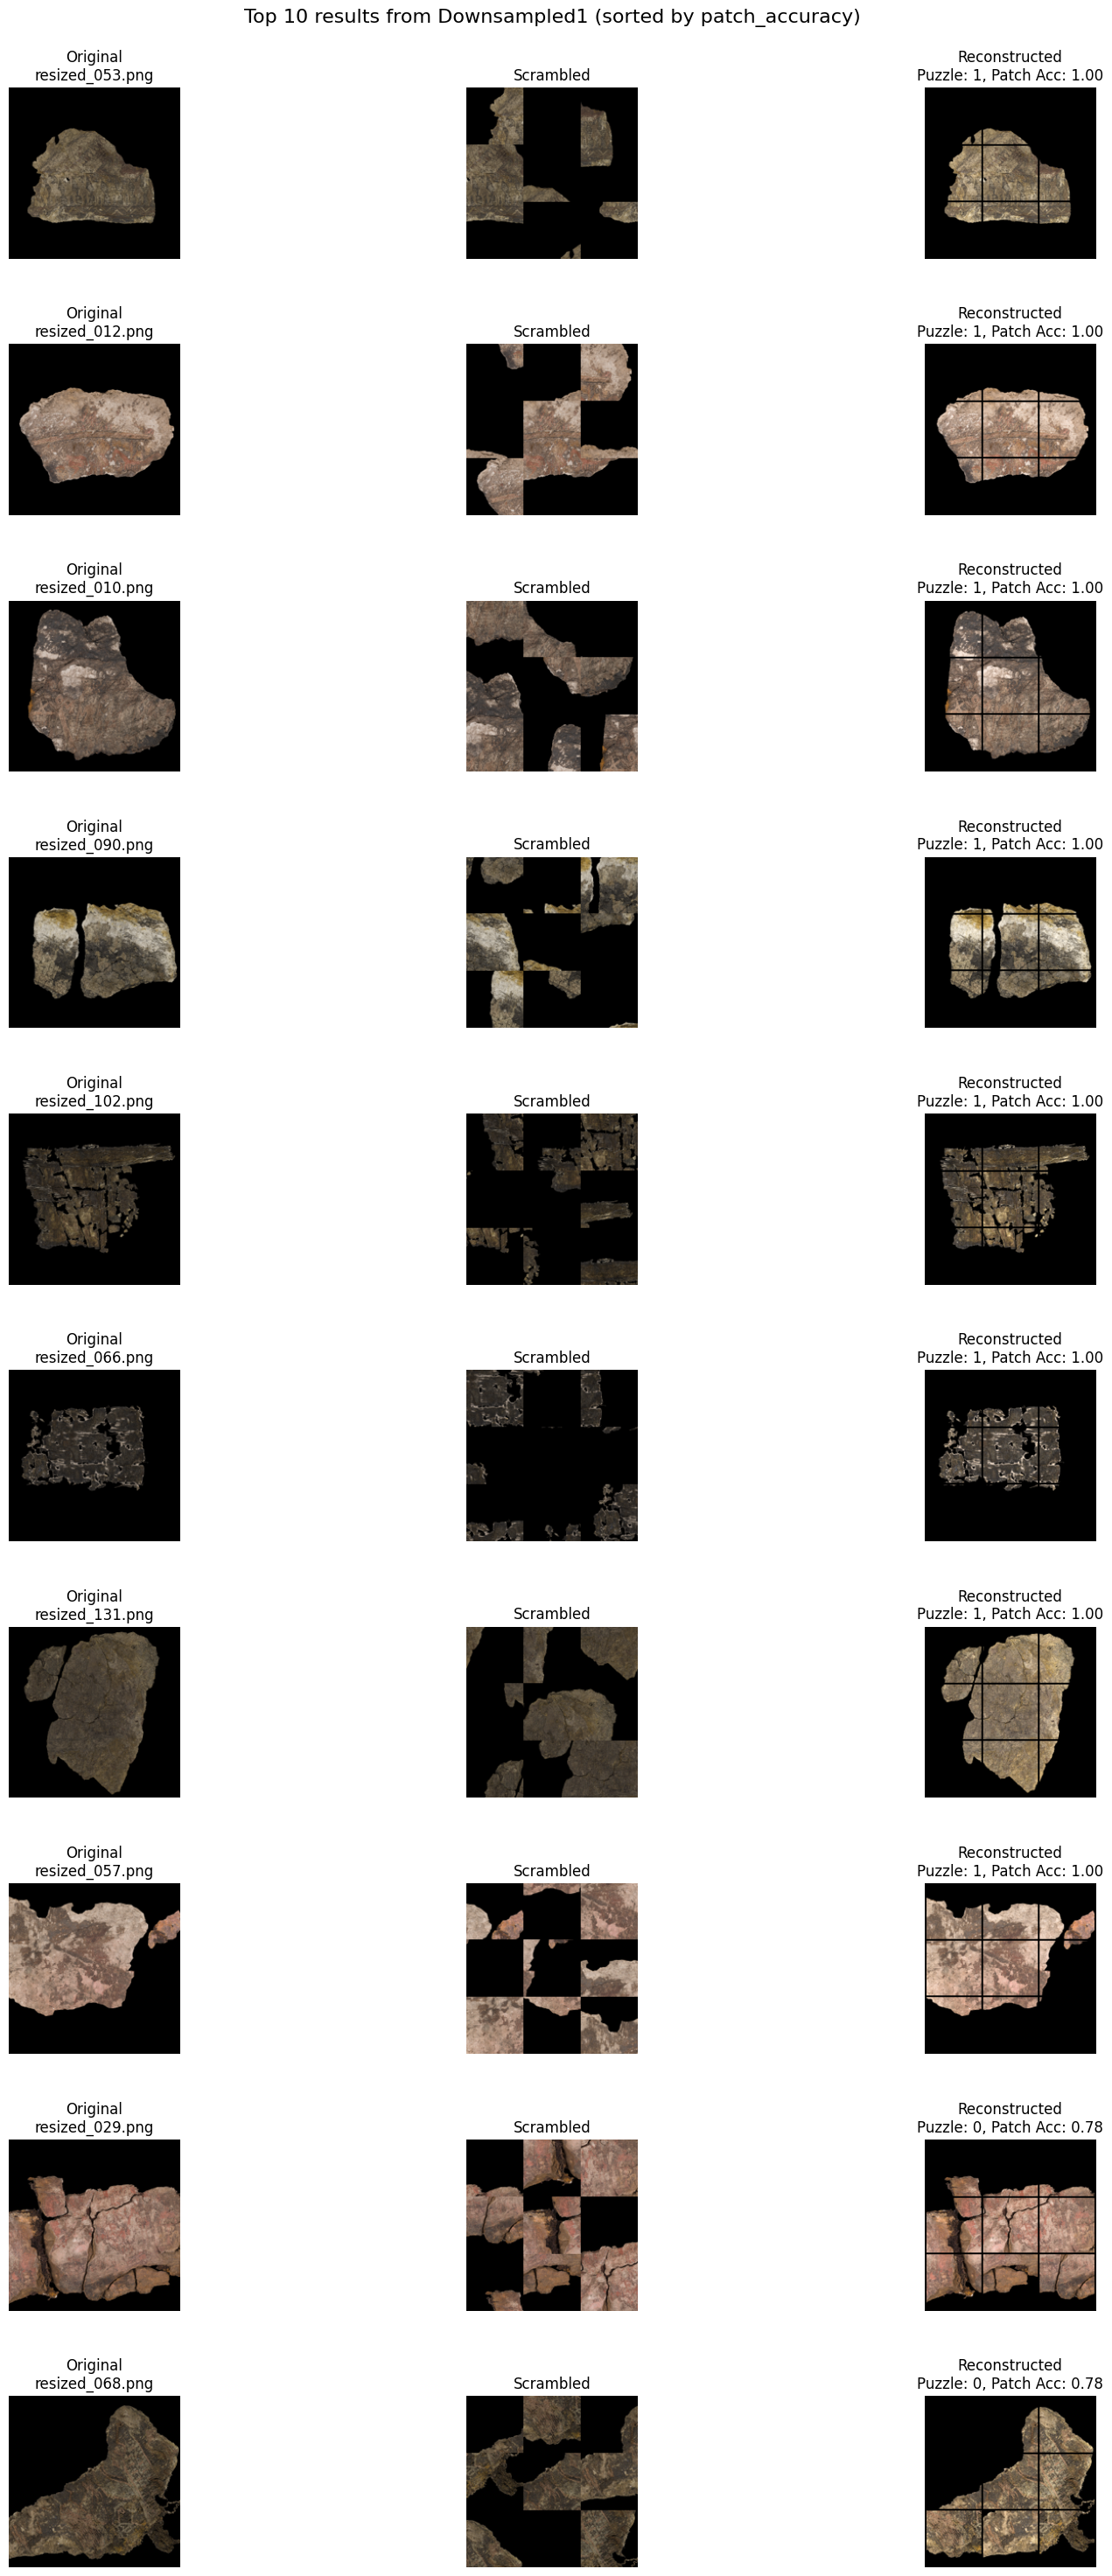


Displayed top 10 images from Downsampled1:
1. resized_053.png - Puzzle: 1, Patch Acc: 1.00
2. resized_012.png - Puzzle: 1, Patch Acc: 1.00
3. resized_010.png - Puzzle: 1, Patch Acc: 1.00
4. resized_090.png - Puzzle: 1, Patch Acc: 1.00
5. resized_102.png - Puzzle: 1, Patch Acc: 1.00
6. resized_066.png - Puzzle: 1, Patch Acc: 1.00
7. resized_131.png - Puzzle: 1, Patch Acc: 1.00
8. resized_057.png - Puzzle: 1, Patch Acc: 1.00
9. resized_029.png - Puzzle: 0, Patch Acc: 0.78
10. resized_068.png - Puzzle: 0, Patch Acc: 0.78


In [9]:
# Sixth cell - Display top 5 results from Downsampled1
display_top_results('Downsampled1', n=10, sort_by='patch_accuracy', ascending=False)

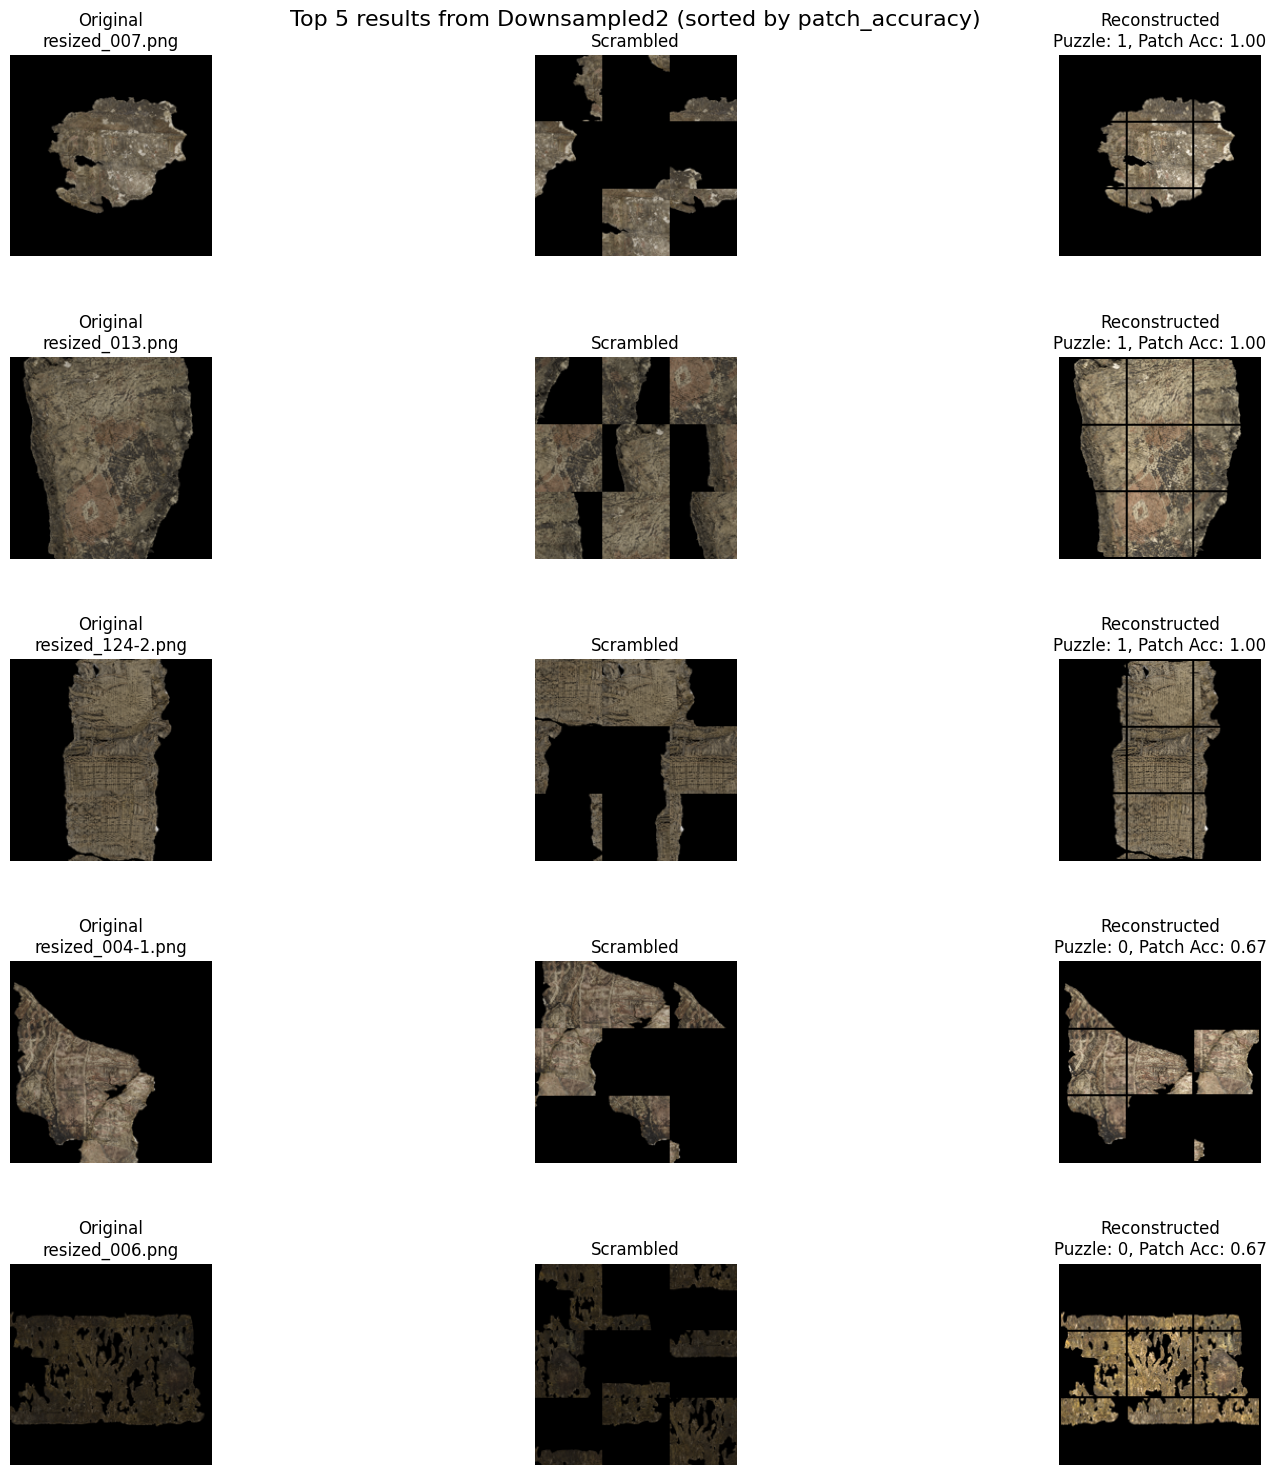


Displayed top 5 images from Downsampled2:
1. resized_007.png - Puzzle: 1, Patch Acc: 1.00
2. resized_013.png - Puzzle: 1, Patch Acc: 1.00
3. resized_124-2.png - Puzzle: 1, Patch Acc: 1.00
4. resized_004-1.png - Puzzle: 0, Patch Acc: 0.67
5. resized_006.png - Puzzle: 0, Patch Acc: 0.67


In [7]:
# Seventh cell - Display top 5 results from Downsampled2
display_top_results('Downsampled2', n=5, sort_by='patch_accuracy', ascending=False)

Downsampled1: Found 8 perfect puzzles


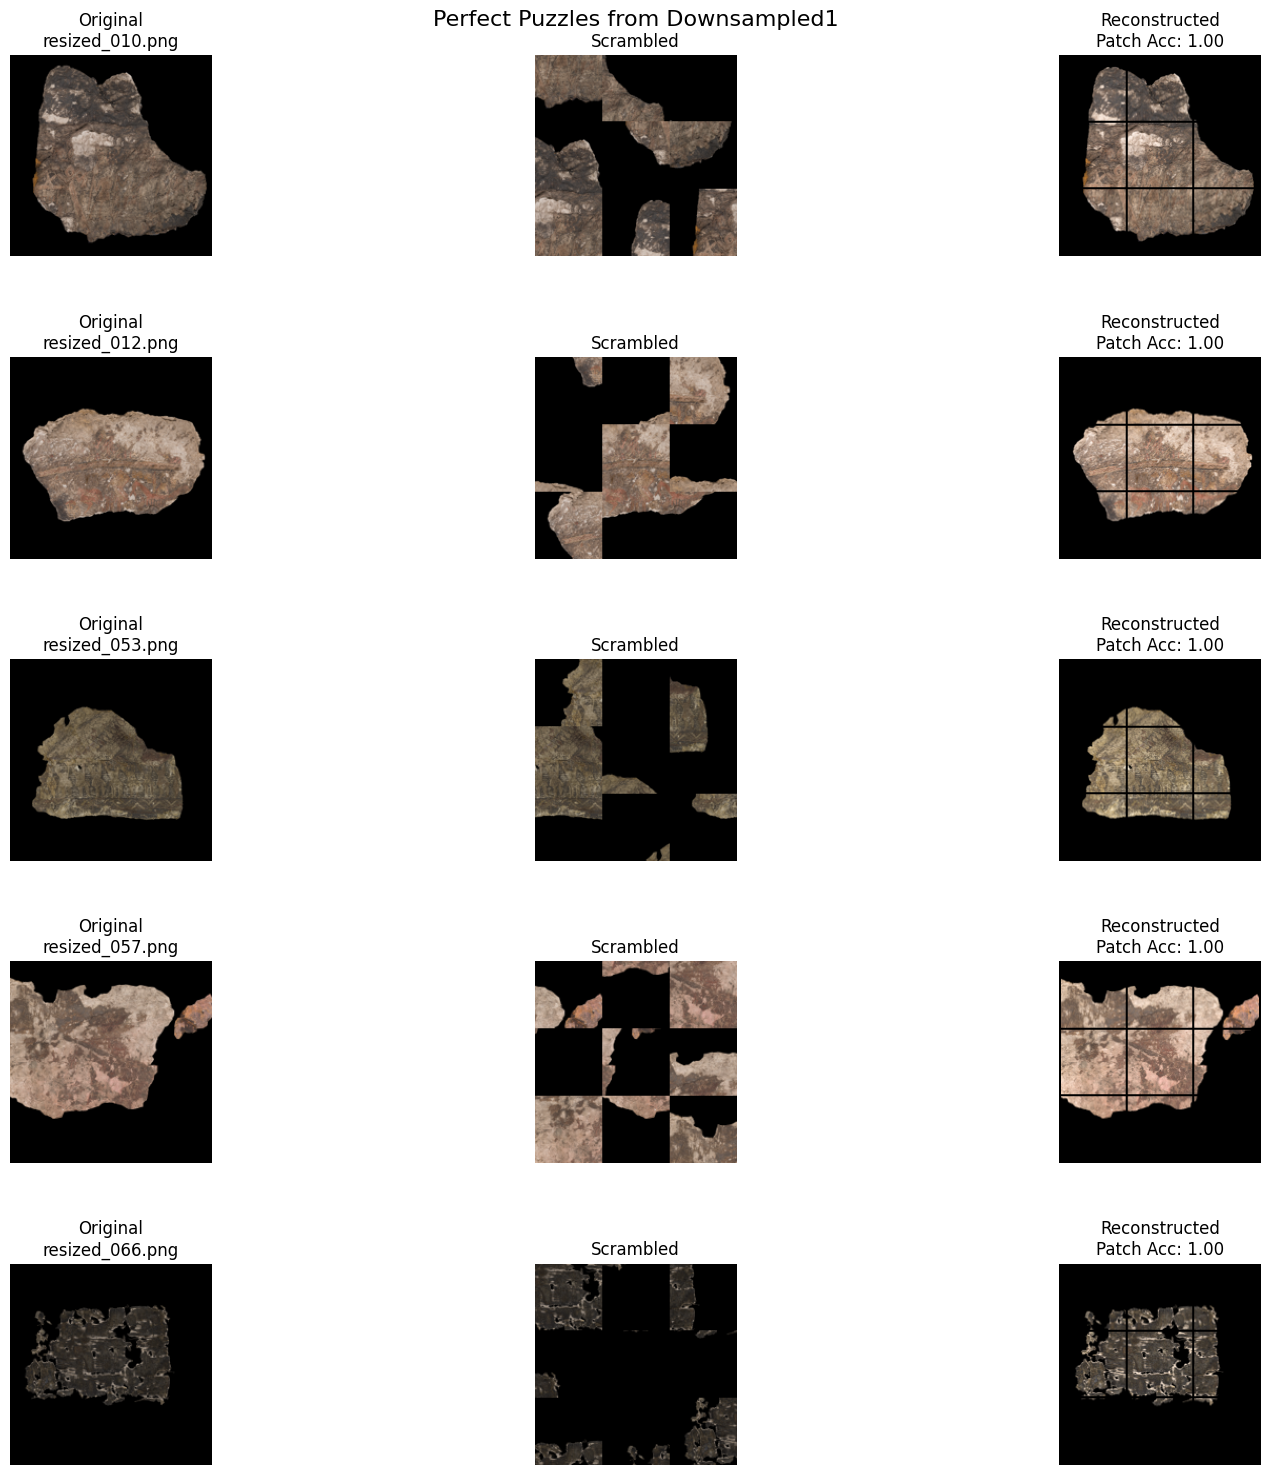

In [8]:
# Eighth cell - Display perfect puzzles from both datasets
# Downsampled1 perfect puzzles
df1 = results_data.get('Downsampled1', pd.DataFrame())
perfect_df1 = df1[df1['puzzle_correct'] == 1]
print(f"Downsampled1: Found {len(perfect_df1)} perfect puzzles")

if len(perfect_df1) > 0:
    # Display up to 5 perfect puzzles
    display_num = min(5, len(perfect_df1))
    fig = plt.figure(figsize=(18, display_num*3))
    plt.suptitle(f"Perfect Puzzles from Downsampled1", fontsize=16)
    
    for i, (idx, row) in enumerate(perfect_df1.head(display_num).iterrows()):
        filename = row['filename']
        puzzle_correct = row['puzzle_correct']
        patch_acc = row['patch_accuracy']
        
        # Get image paths
        orig_path, scrambled_path, recon_path = find_image_path('Downsampled1', filename, puzzle_correct, patch_acc)
        
        if not all(os.path.exists(p) for p in [orig_path, scrambled_path, recon_path]):
            continue
            
        ax1 = fig.add_subplot(display_num, 3, i*3+1)
        ax1.imshow(Image.open(orig_path))
        ax1.set_title(f"Original\n{os.path.basename(filename)}")
        ax1.axis('off')
        
        ax2 = fig.add_subplot(display_num, 3, i*3+2)
        ax2.imshow(Image.open(scrambled_path))
        ax2.set_title("Scrambled")
        ax2.axis('off')
        
        ax3 = fig.add_subplot(display_num, 3, i*3+3)
        ax3.imshow(Image.open(recon_path))
        ax3.set_title(f"Reconstructed\nPatch Acc: {patch_acc:.2f}")
        ax3.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, top=0.95)
    plt.show()